### TODO:

Train with extending windows 1960-X, to show if the forecast improves for later years.

Weigh average correctly


### Writeup

- Introduction 1000 words
 
- Background 4000

Rest for the corpus

- Methods (Data)

- Results and discussion
    - evolution of means of production
    - relevance of critics
    - climate change

These points must be present in the background search

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')
plt.rcParams['figure.figsize']= [12, 4]

df_st_em = pd.read_excel('data/generated_features_st_em.xlsx', index_col=0).loc[1960:2017]
df_medoc = pd.read_excel('data/generated_features_medoc.xlsx', index_col=0).loc[1960:2017]

display(df_medoc.head())

,Tn: budburst - flowering,Tn: fleur,Tn: flowering - véraison,Tn: véraison - harvest,Tn: harvest,Tm: budburst - flowering,Tm: fleur,Tm: flowering - véraison,Tm: véraison - harvest,Tm: harvest,...,P: fleur,P: flowering - véraison,P: véraison - harvest,P: harvest,Frost: budburst - flowering,Growing Season Tm,Winter Rain,GDD10,Stress,Log price
1960,9.054412,14.485714,15.455385,14.993333,13.190909,12.882353,18.628571,19.030769,18.444444,15.513636,...,1.1,118.8,140.9,209.9,0.0,16.948634,0.000000,1989.8,-77.35,5.822200
1961,8.794118,10.453333,15.214706,15.502273,14.767857,12.645588,14.573333,18.823529,19.543182,18.392857,...,35.7,90.0,14.3,92.6,0.0,17.506011,5.003289,2249.1,94.40,7.321283
1962,9.800000,14.020000,15.606557,14.308511,11.209091,13.421429,18.350000,19.372131,18.642553,14.913636,...,8.8,37.2,50.4,44.3,0.0,16.615847,3.417763,2111.4,106.75,6.324487
1963,10.750746,14.475000,15.715789,14.208333,11.385714,13.837313,17.250000,19.056140,16.883333,14.575000,...,1.1,158.6,139.7,32.1,0.0,16.104372,2.480921,1961.5,-146.10,5.889768
1964,10.868421,15.400000,15.845902,16.165000,12.323333,14.382456,18.335714,19.865574,19.725000,15.126667,...,54.4,32.5,60.2,215.0,0.0,17.648087,1.697386,2232.2,100.05,5.810285


In [2]:
def r_squared(x, y):
    return 1 - np.sum(np.square(x - y))/np.sum(np.square(x - np.mean(x)))

print(r_squared(np.array([1, 2, 3]), np.array([2,2,2])))

0.0


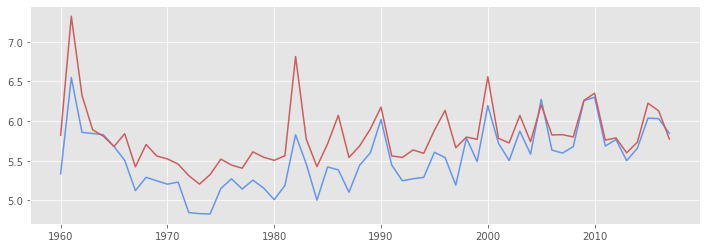

In [3]:
from sklearn.preprocessing import StandardScaler

X_st_em = df_st_em.drop('Log price', axis=1)

X_st_em = pd.DataFrame(StandardScaler().fit_transform(X_st_em), index=X_st_em.index, columns=X_st_em.columns).loc[1960:,:]

COLUMN_NAMES = X_st_em.columns.to_list()
y_st_em = df_st_em[['Log price']]
plt.plot(y_st_em, color = 'cornflowerblue')

X_medoc = df_medoc.drop('Log price', axis=1)

X_medoc = pd.DataFrame(StandardScaler().fit_transform(X_medoc), index=X_medoc.index, columns=X_medoc.columns).loc[1960:,:]

COLUMN_NAMES = X_medoc.columns.to_list()
y_medoc = df_medoc[['Log price']]
plt.plot(y_medoc, color = 'indianred')

In [90]:
init_dict = {
    'Growing Season Tm':-0.1,
    #'Square Growing Season Tm':-0.1,
    'DTR: veraison - vendanges':0.2,
    'P: veraison - vendanges':-0.2,
    'Stress':0.2,
    'P: fleur':-0.1,
    'Wind: fleur':0.1,
    'Tm: floraison - veraison':0.1,
    'Floraison-veraison interval':-0.1,
    'Tx: debourrement - floraison':0.1,
    'DTR: debourrement - floraison':-0.1,
    'ETP: veraison - vendanges':0.1,
    'Dormancy':0.1,
}

In [103]:
class Regressive_Model_Single(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length, model_features):
        super().__init__()
        
        self.weights = {}
        self.length = length
        self.type = {}
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(-0.1*np.ones(self.length)))

        self.walk_params = torch.nn.ParameterList([])
        for feature in model_features:
            if feature in init_dict.keys():
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(0.1*np.random.randn(self.length))))

        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in model_features]
        
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in []]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    
    def loss_regularize_intercept(self):
        return torch.mean(torch.square(self.weights_intercept[1:] - self.weights_intercept[:-1]))\
    /torch.max(torch.abs(self.weights_intercept))
    
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean(torch.square(t[1:] - t[:-1])) / torch.max(torch.abs(t))
        return loss
    
    def loss_target(self, X, y):
        return torch.mean(torch.square(y - self.forward(X)))    
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 20* self.loss_regularize_walk_coeffs()\
                + 20*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()
        
def training_loop_single(model, name, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n), desc = name, leave = False):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

'Sun: veraison - vendanges' improves medoc R2 to .2

Best overall : with P: vendanges, 
>Spearman correlation between results and real log prices: 
> 0.8878260869565217
>
>R2 between results and real log prices: 
> 0.31347239989979714


Double one : ['Wind: fleur', 'Stress','DTR: veraison - vendanges', 'P: fleur', 'P: vendanges']

>Spearman correlation between results and real log prices: 
> 0.8791304347826084
> 
>R2 between results and real log prices: 
> 0.33702659011920744



10 000 iterations, ['Wind: fleur', 'Stress','DTR: veraison - vendanges', 'P: fleur'], bayesian

>Combined:
>
>Spearman correlation between results and real log prices: 
> 0.8130434782608694
> 
>R2 between results and real log prices: 
> 0.5108363926448425
 
Same, non bayesian


>Combined:
>
>Spearman correlation between results and real log prices: 
> 0.8130434782608694
> 
>R2 between results and real log prices: 
> 0.614242599469981

- Same, 3000 iterations : exact same result
- Same with 2000 iterations
- Same with 1000 iterations
- 500 iterations:

>Combined:
>
>Spearman correlation between results and real log prices: 
> 0.8156521739130433
> 
>R2 between results and real log prices: 
> 0.6153449351929356

##### => Keep 500 iterations

In [104]:
def extrapolate_coeffs(walks, year_range, vintage, verbose = False):
    next_coeffs = []
    for walk in walks:
        
        linreg = LinearRegression()
        linreg.fit(year_range[-20:], walk[-20:])
        #if verbose:
        #    print(walks)
        #    print(linreg.predict(np.array(vintage).reshape(-1,1)))
        next_coeffs.append(linreg.predict(np.array(vintage).reshape(-1,1)))
    return next_coeffs

In [105]:
results_df = pd.DataFrame(index = [
    'Médoc: SpearmanR',
    'Saint-Émilion: SpearmanR',
    'Global: SpearmanR',
    'Médoc: R2',
    'Saint-Émilion: R2',
    'Global: R2',
    'Médoc: MAE',
    'Saint-Émilion: MAE',
    'Global: MAE'
])
results_df['Separate VarCoef'] = 0

def score_predictions(predictions, y):  
    spearman_r = round(spearmanr(y.loc[1994:2017], predictions.loc[1994:2017])[0], 3)
    mae = round(np.mean(np.abs(predictions.loc[1994:2017].values- y.loc[1994:2017].values)), 3)
    r2 = round(r2_score(y.loc[1994:2017].values, predictions.loc[1994:2017].values), 3)
    return spearman_r, r2, mae

# Simple Regression : Saint Emilion

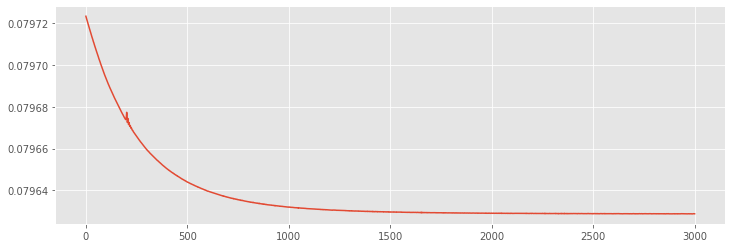

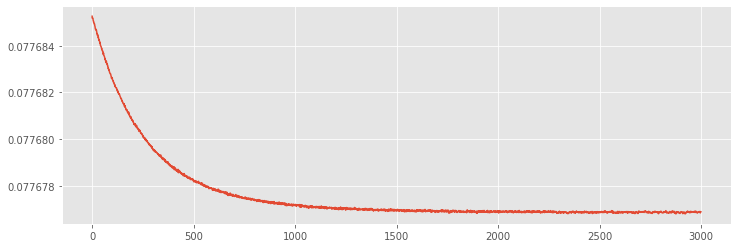

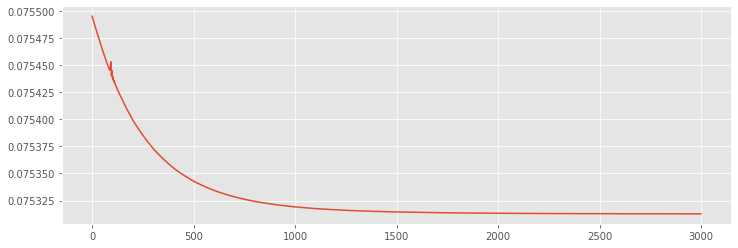

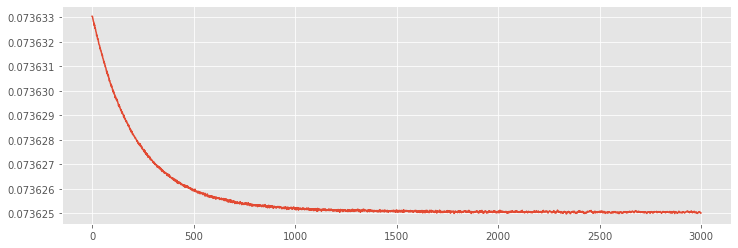

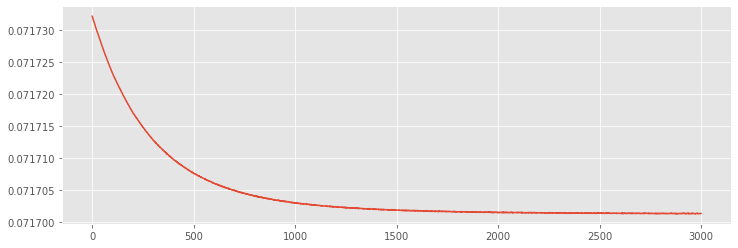

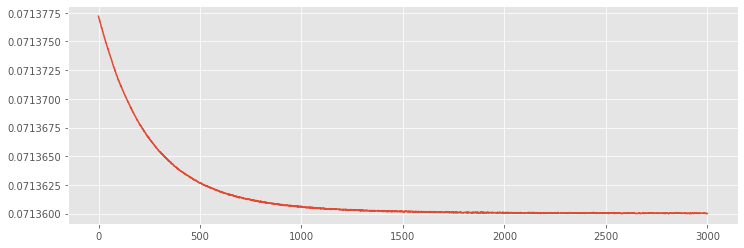

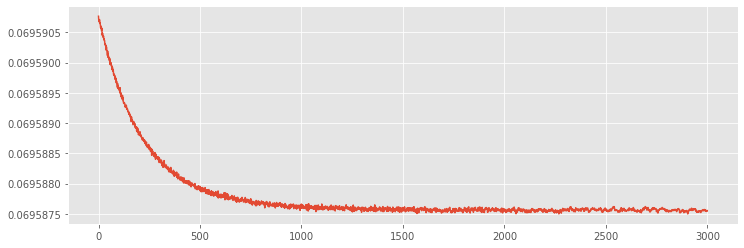

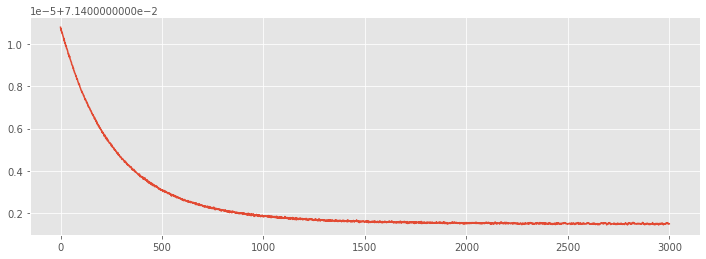

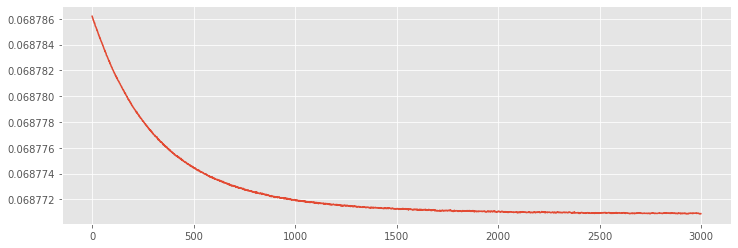

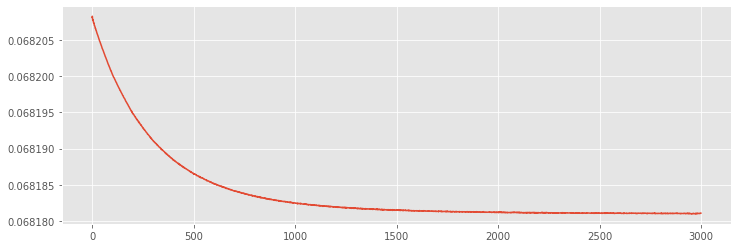

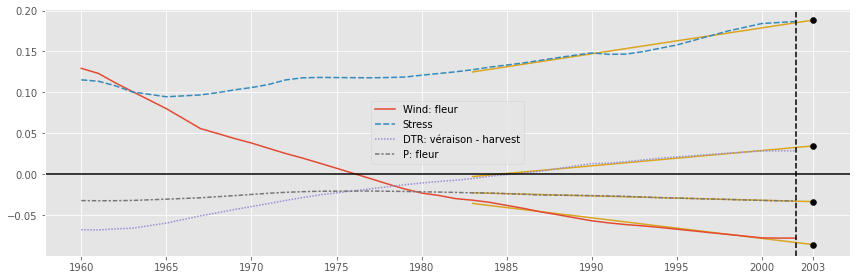

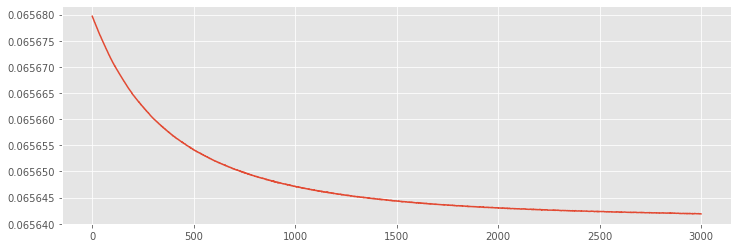

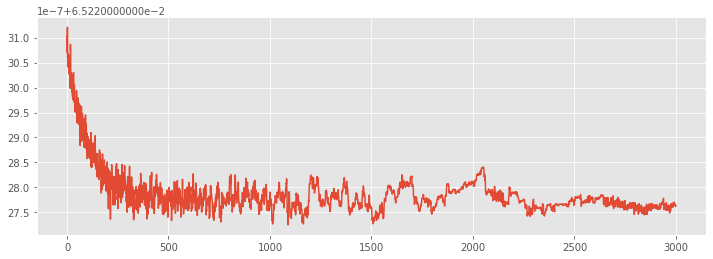

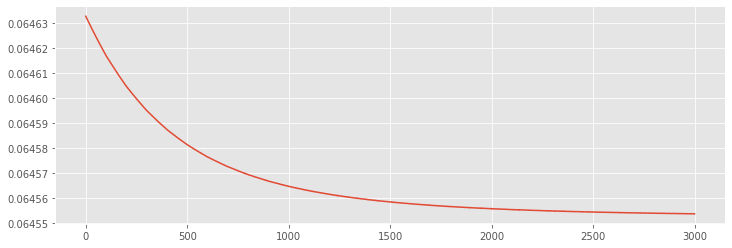

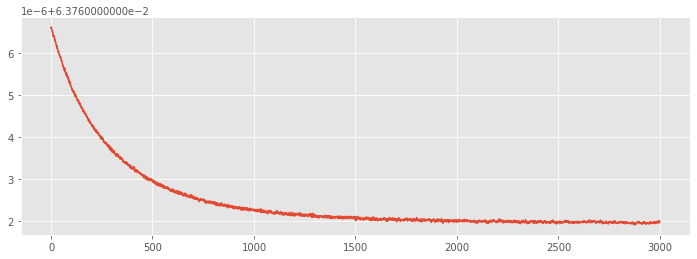

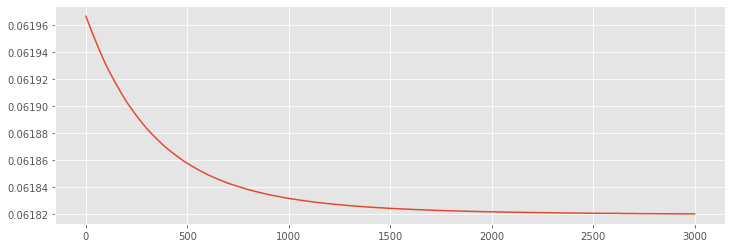

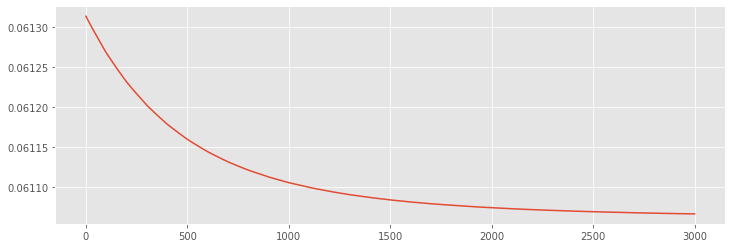

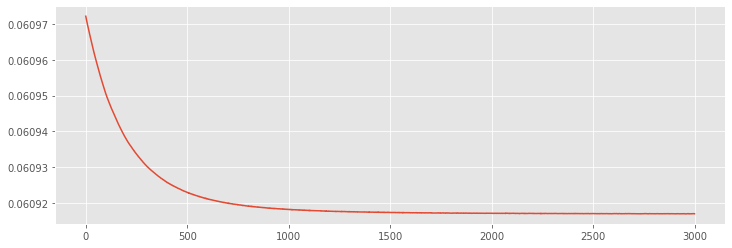

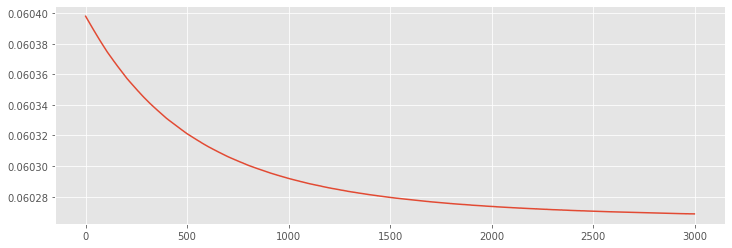

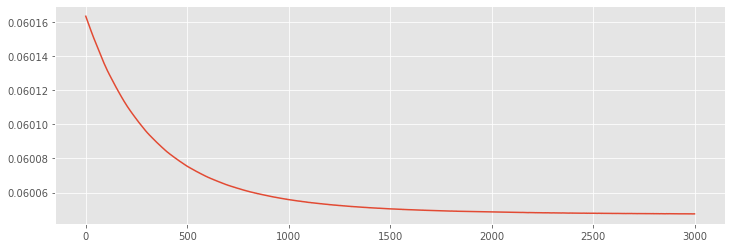

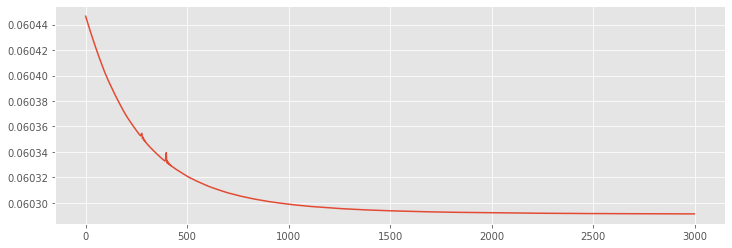

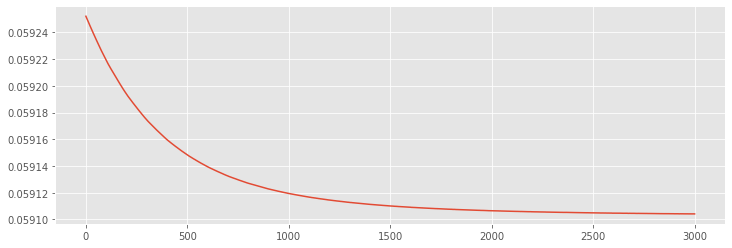

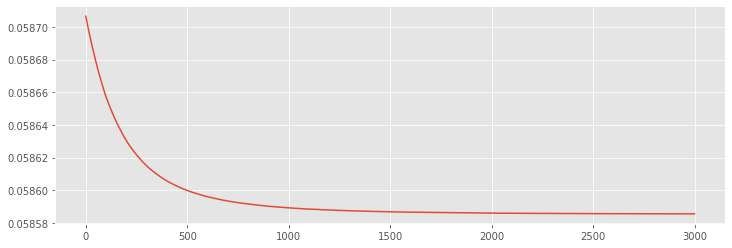

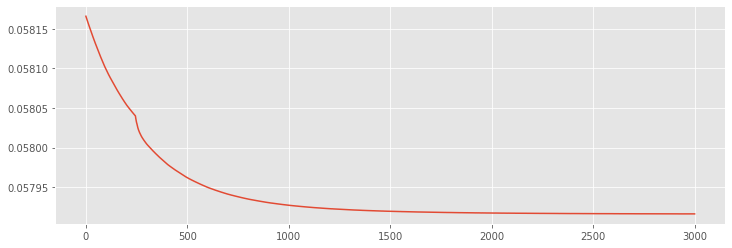

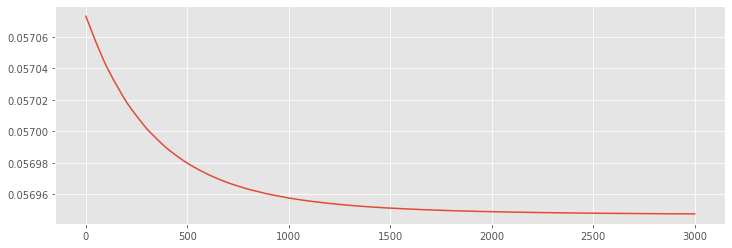

FINISHED


In [107]:
#GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']
GOOD_FEATURES = ['Wind: fleur', 'Stress','DTR: véraison - harvest', 'P: fleur']
coefficients_df_st_em = pd.DataFrame(index = range(1994, 2018), columns = ['intercept st_em'] + GOOD_FEATURES)
next_coefficients_df_st_em = pd.DataFrame(index = range(1994, 2019), columns = ['intercept st_em'] + GOOD_FEATURES)
next_next_coefficients_df_st_em = pd.DataFrame(index = range(1994, 2020), columns = ['intercept st_em'] + GOOD_FEATURES)

for vintage in range(1994, 2018):
    FIRST = 1960
    LAST = vintage - 1
    
    X_tensor = torch.FloatTensor(X_st_em.loc[FIRST : LAST, :].values)
    y_tensor = torch.from_numpy(y_st_em.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    vintage_model = Regressive_Model_Single(init_dict, training_length, GOOD_FEATURES)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.90)
    losses = training_loop_single(vintage_model, str(vintage), optimizer, scheduler, 4000)
    plt.plot(losses[1000:])
    plt.show()
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df_st_em.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df_st_em.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]
    next_next_coefficients_df_st_em.loc[vintage + 2, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 2)]

    coefficients_df_st_em.loc[vintage, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df_st_em.loc[vintage + 1, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df_st_em.loc[vintage + 2, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 2)[0][0]
    
    
    if vintage == 2003:
        coeff_df = pd.DataFrame(index = model_year_range.ravel(), columns = GOOD_FEATURES)
        for i in range(len(GOOD_FEATURES)):
            feature = GOOD_FEATURES[i]
            walk = vintage_model.walk_params[i].detach().numpy()
            coeff_df[feature] = walk
            linreg = LinearRegression()
            linreg.fit(np.array(range(vintage-20, vintage)).reshape(-1,1), walk[-20:])
            plt.plot(range(vintage-20, vintage + 1), linreg.predict(np.array(range(vintage-20, vintage + 1)).reshape(-1,1)), color='goldenrod')
            plt.scatter(vintage, linreg.predict(np.array(vintage).reshape(-1,1)), color = 'k', zorder=10)
        sns.lineplot(data = coeff_df)
        plt.axhline(0, color = 'k')
        plt.axvline(vintage - 1, color = 'k', linestyle='--')
        plt.gca().set_xticks(list(range(FIRST, LAST, 5))+[vintage])
        plt.tight_layout()
        plt.savefig('views/extrapolation.png')
        plt.show()

print('FINISHED')

In [108]:
pnew = 1
pold = 0

predictions_st_em = pd.DataFrame(index = range(1994, 2018), columns = ['Log price'])

for vintage in tqdm(range(1994, 2018)):  
    prediction = 6
    if vintage == 1994:
        prediction = 6 + coefficients_df_st_em.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction += coefficients_df_st_em.loc[vintage, feature] * X_st_em.loc[vintage, feature]
    
    else:
        prediction = 6 
        prediction += pnew * coefficients_df_st_em.loc[vintage, 'intercept st_em'] + pold * next_coefficients_df_st_em.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction += (pnew * coefficients_df_st_em.loc[vintage, feature] + pold * next_coefficients_df_st_em.loc[vintage, feature]) * X_st_em.loc[vintage, feature]
    predictions_st_em.loc[vintage, 'Log price'] = prediction

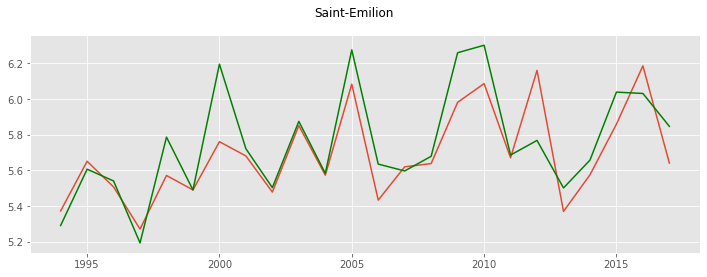

0.871 | 0.648 | 0.312


In [109]:
plt.plot(range(1994, 2018), predictions_st_em)
plt.suptitle('Saint-Emilion')
plt.plot(y_st_em.loc[1994:2017, 'Log price'], color='g')
plt.show()

spearman_r, r2, mae = score_predictions(predictions_st_em, y_st_em['Log price'])
print(spearman_r, '|', r2, '|', mae)
results_df.iloc[1::3, 0] = score_predictions(predictions_st_em, y_st_em['Log price'])

### Simple Regression : Medoc

In [111]:
GOOD_FEATURES = ['Stress', 'DTR: véraison - harvest', 'P: fleur', 'Wind: fleur']
coefficients_df_medoc = pd.DataFrame(index = range(1994, 2018), columns = ['intercept medoc'] + GOOD_FEATURES)
next_coefficients_df_medoc = pd.DataFrame(index = range(1994, 2019), columns = ['intercept medoc'] + GOOD_FEATURES)
next_next_coefficients_df_medoc = pd.DataFrame(index = range(1994, 2020), columns = ['intercept medoc'] + GOOD_FEATURES)

for vintage in range(1994, 2018):
    FIRST = 1960
    LAST = vintage - 1
    
    X_tensor = torch.FloatTensor(X_medoc.loc[FIRST : LAST, :].values)
    y_tensor = torch.from_numpy(y_medoc.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    vintage_model = Regressive_Model_Single(init_dict, training_length, GOOD_FEATURES)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    losses = training_loop_single(vintage_model, str(vintage), optimizer, scheduler, 4000)
    
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df_medoc.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df_medoc.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]
    next_next_coefficients_df_medoc.loc[vintage + 2, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 2)]

    coefficients_df_medoc.loc[vintage, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df_medoc.loc[vintage + 1, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df_medoc.loc[vintage + 2, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 2)[0][0]
    
    
print('FINISHED')

FINISHED


In [112]:
pnew = 1
pold = 0

predictions_medoc = pd.DataFrame(index = range(1994, 2018), columns = ['Log price'])

for vintage in tqdm(range(1994, 2018)):  
    prediction = 6
    if vintage == 1994:
        prediction = 6 + coefficients_df_medoc.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction += coefficients_df_medoc.loc[vintage, feature] * X_medoc.loc[vintage, feature]
    
    else:
        prediction = 6 
        prediction += pnew * coefficients_df_medoc.loc[vintage, 'intercept medoc'] + pold * next_coefficients_df_medoc.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction += (pnew * coefficients_df_medoc.loc[vintage, feature] + pold * next_coefficients_df_medoc.loc[vintage, feature]) * X_medoc.loc[vintage, feature]
    predictions_medoc.loc[vintage, 'Log price'] = prediction

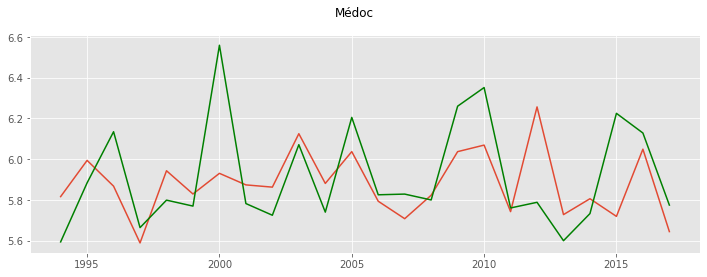

0.5 | 0.149 | 0.235


In [113]:
plt.plot(range(1994, 2018), predictions_medoc)
plt.suptitle('Médoc')
plt.plot(y_medoc.loc[1994:2017, 'Log price'], color='g')
plt.show()

spearman_r, r2, mae = score_predictions(predictions_medoc, y_medoc['Log price'])
print(spearman_r, '|', r2, '|', mae)
results_df.iloc[0::3, 0] = score_predictions(predictions_medoc, y_medoc['Log price'])

In [114]:
predictions_global = 0.5*(predictions_medoc + predictions_st_em)
y_average = 0.5 * (df_medoc['Log price'] + df_st_em['Log price'])

results_df.iloc[2::3, 0] = score_predictions(predictions_global, y_average)
display(results_df)

,Separate VarCoef
Médoc: SpearmanR,0.500
Saint-Émilion: SpearmanR,0.871
Global: SpearmanR,0.783
Médoc: R2,0.149
Saint-Émilion: R2,0.648
Global: R2,0.486
Médoc: MAE,0.235
Saint-Émilion: MAE,0.312
Global: MAE,0.256


In [65]:
#coefficients_df_medoc[coefficients_df_medoc.columns] = coefficients_df_medoc.apply(lambda x: x.astype(float))
#coefficients_df_st_em[coefficients_df_st_em.columns] = coefficients_df_st_em.apply(lambda x: x.astype(float))
#coefficients_df_medoc.columns = ['Medoc: ' + col for col in coefficients_df_medoc.columns]
#coefficients_df_st_em.columns = ['St Em: ' + col for col in coefficients_df_st_em.columns]
#
#sns.lineplot(data = pd.concat((coefficients_df_medoc.iloc[:, 1:], coefficients_df_st_em.iloc[:, 1:]), axis = 0))
#
#plt.show()

# Combined model : Medoc and Saint Emilion

In [115]:
class Regressive_Model_Combined(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length, model_features, bayesian = False):
        super().__init__()
        
        self.bayesian = bayesian
        self.weights = {}
        self.length = length
        self.type = {}
        self.weights_intercept_st_em = torch.nn.Parameter(torch.from_numpy(-0.1*np.ones(self.length)))
        self.weights_intercept_medoc = torch.nn.Parameter(torch.from_numpy(-0.1*np.ones(self.length)))

        self.walk_params = torch.nn.ParameterList([])
        for feature in model_features:
            if feature in init_dict.keys():
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(0.1*np.random.randn(self.length))))

        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in model_features]
        
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in []]
        
        if self.bayesian:
            self.intercept_st_em_logvar = torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length)))
            self.intercept_medoc_logvar = torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length)))

            self.walk_logvars = torch.nn.ParameterList([])
            for feature in GOOD_FEATURES:
                self.walk_logvars.append(torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length))))
        
            
    def sample_walks(self):
        walk_sample = []
        for i in range(len(self.walk_params)):
            walk_sample.append(self.walk_params[i] + torch.randn_like(self.walk_params[i]) * torch.exp(0.5 * self.walk_logvars[i])) # Element-wise multiplication of epsilon with variance
        return walk_sample

    
    
    def forward_st_em(self, X):
        """ 
        Forward pass of the model on one vintage for St Emilion
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_st_em
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def forward_st_em_bayesian(self, X):
        """ 
        Forward pass of the model on one vintage for St Emilion, bayesian sampling
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_st_em + torch.randn_like(self.weights_intercept_st_em) * torch.exp(0.5 * self.intercept_st_em_logvar)
        
        walks = self.sample_walks()
        for i in range(len(walks)):
            result += walks[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def forward_medoc(self, X):
        """ 
        Forward pass of the model on one vintage for Medoc
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_medoc
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def forward_medoc_bayesian(self, X):
        """ 
        Forward pass of the model on one vintage for St Emilion, bayesian sampling
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_medoc + torch.randn_like(self.weights_intercept_medoc) * torch.exp(0.5 * self.intercept_medoc_logvar)
        
        walks = self.sample_walks()
        for i in range(len(walks)):
            result += walks[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean(torch.square(self.weights_intercept_st_em[1:] - self.weights_intercept_st_em[:-1]))\
    /torch.max(torch.abs(self.weights_intercept_st_em)) +\
            torch.mean(torch.square(self.weights_intercept_medoc[1:] - self.weights_intercept_medoc[:-1]))\
    /torch.max(torch.abs(self.weights_intercept_medoc))
    
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean(torch.square((t[1:] - t[:-1]))) / torch.max(torch.abs(t))
        return loss
    
    def loss_target_bayesian(self, X, y, zone):
        if zone == 'st_em':
            return torch.mean(torch.square(y - self.forward_st_em_bayesian(X)))
        else:
            return torch.mean(torch.square(y - self.forward_medoc_bayesian(X)))
            
    def loss_target(self, X, y, zone):
        if zone == 'st_em':
            return torch.mean(torch.square(y - self.forward_st_em(X)))
        else:
            return torch.mean(torch.square(y - self.forward_medoc(X)))
    
    
    def combined_loss(self, X, y, zone):
        return self.loss_target(X, y, zone) + 20*self.loss_regularize_walk_coeffs()\
                + 20*self.loss_regularize_intercept()

    def combined_loss_bayesian(self, X, y, zone):
        return self.loss_target_bayesian(X, y, zone) + 20*self.loss_regularize_walk_coeffs()\
                + 20*self.loss_regularize_intercept()
    
        
def training_loop_combined(model, name, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n), desc = name, leave=False):
        loss = 0.5 * model.combined_loss(X_tensor_medoc, y_tensor_medoc, 'medoc') + 0.5 * model.combined_loss(X_tensor_st_em, y_tensor_st_em, 'st_em')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

def training_loop_combined_bayesian(model, name, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    size_X = list(X_tensor_medoc.size())
    size_y = list(y_tensor_st_em.size())
    for i in tqdm(range(n), desc = name, leave=False):
        epsilon_X = 0.1*np.random.rand(*size_X)
        epsilon_y = 0.1*np.random.rand(*size_y)
        loss = 0.5 * model.combined_loss_bayesian(X_tensor_medoc + epsilon_X, y_tensor_medoc + epsilon_y, 'medoc') \
             + 0.5 * model.combined_loss_bayesian(X_tensor_st_em + epsilon_X, y_tensor_st_em + epsilon_y, 'st_em')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

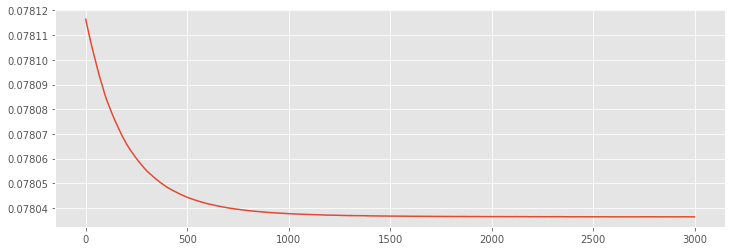

In [116]:
X_tensor_st_em = torch.FloatTensor(X_st_em.values)
y_tensor_st_em = torch.from_numpy(y_st_em['Log price'].values)
X_tensor_medoc = torch.FloatTensor(X_medoc.values)
y_tensor_medoc = torch.from_numpy(y_medoc['Log price'].values)

GOOD_FEATURES = ['Wind: fleur', 'Stress','DTR: harvest', 'P: fleur']

bayesian=False

model = Regressive_Model_Combined(init_dict, len(y_st_em), GOOD_FEATURES, bayesian=bayesian)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.90)

if bayesian:
    losses = training_loop_combined_bayesian(model, 'General',optimizer, scheduler, 4000)
else:
    losses = training_loop_combined(model, 'General', optimizer, scheduler, 4000)
plt.plot(losses[1000:])
plt.show()

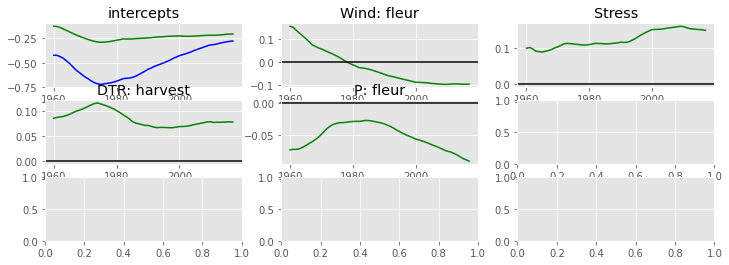

In [117]:
fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1960, 2018), model.weights_intercept_st_em.detach().numpy(), color='blue')
subplot.plot(range(1960, 2018), model.weights_intercept_medoc.detach().numpy(), color='green')

subplot.set_title('intercepts')
for i in range(len(model.walk_params)):
    n = i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(1960, 2018), model.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[model.where_to_find_walks[i]])
plt.show()

#optimal_temp =  (- model.walk_params[0].detach().numpy() / (2*model.walk_params[1].detach().numpy()))*18 # x = -b/2a
#plt.plot(optimal_temp)

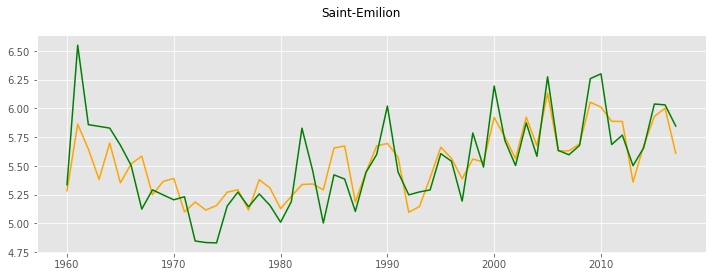

Spearman correlation between results and real log prices: 
 0.8678260869565216
R2 between results and real log prices: 
 0.7657809064447408


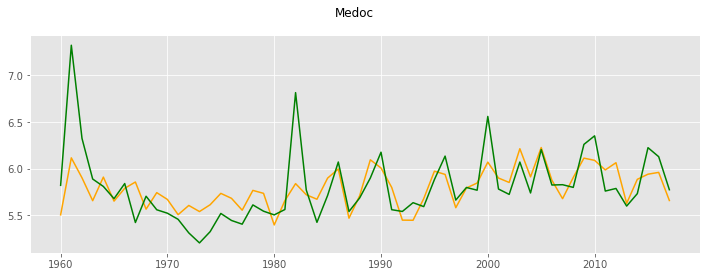

Spearman correlation between results and real log prices: 
 0.7156521739130434
R2 between results and real log prices: 
 0.4860302381060484

Combined:
Spearman correlation between results and real log prices: 
 0.8017391304347825
R2 between results and real log prices: 
 0.6070493342445411


In [118]:
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score

full_predictions_st_em  = model.forward_st_em(X_tensor_st_em).detach().numpy()
predictions_st_em = full_predictions_st_em[34:]

plt.plot(range(1960, 2018), full_predictions_st_em, color='orange')
plt.plot(y_st_em['Log price'], color='g')
plt.suptitle('Saint-Emilion')
plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_st_em, y_st_em.loc[1994:, 'Log price']).correlation)
print('R2 between results and real log prices: \n', r2_score(y_st_em.loc[1994:, 'Log price'], predictions_st_em))

full_predictions_medoc  = model.forward_medoc(X_tensor_medoc).detach().numpy()
predictions_medoc = full_predictions_medoc[34:]
plt.plot(range(1960, 2018), full_predictions_medoc, color='orange')
plt.plot(y_medoc['Log price'], color='g')
plt.suptitle('Medoc')

plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_medoc, y_medoc.loc[1994:, 'Log price']).correlation)
print('R2 between results and real log prices: \n', r2_score(y_medoc.loc[1994:, 'Log price'], predictions_medoc))

predictions_combined = np.log(0.5 * np.exp(predictions_medoc) + 0.5 * np.exp(predictions_st_em))
mean_price = np.log(0.5*np.exp(y_st_em.loc[1994:2017, 'Log price'].values) + 0.5*np.exp(y_st_em.loc[1994:2017, 'Log price'].values))
print('\nCombined:')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_combined, mean_price).correlation)
print('R2 between results and real log prices: \n', r2_score(mean_price, predictions_combined))

### Ex Ante

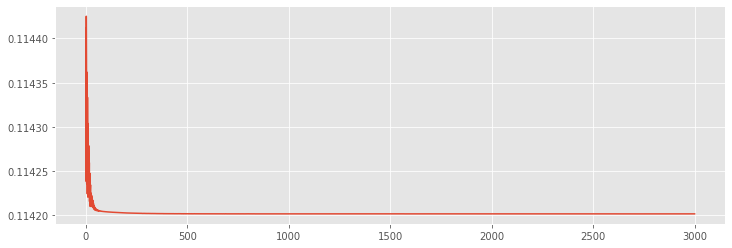

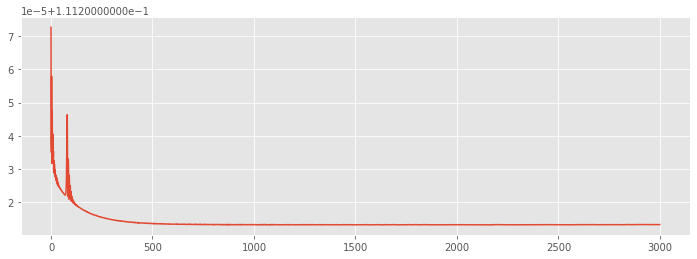

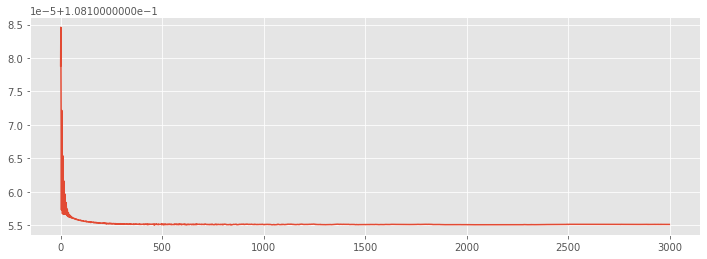

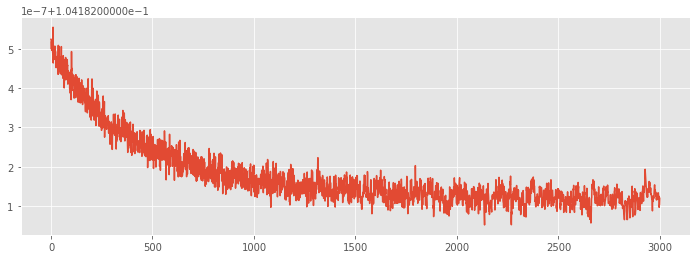

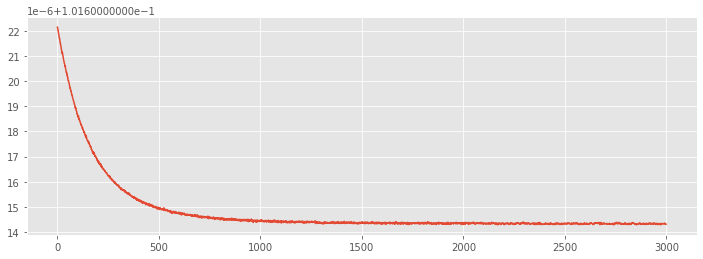

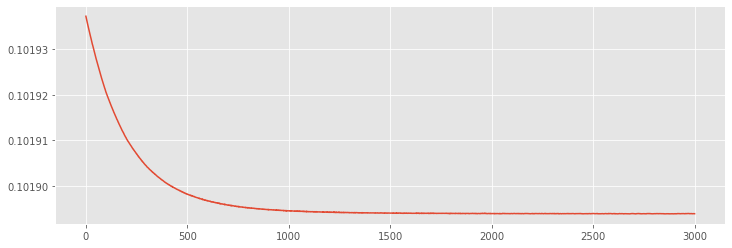

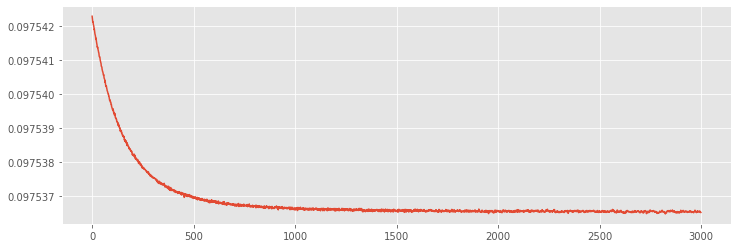

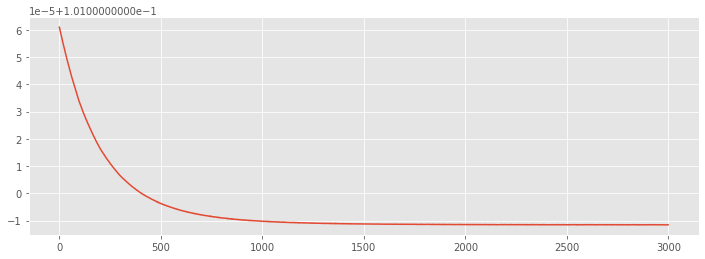

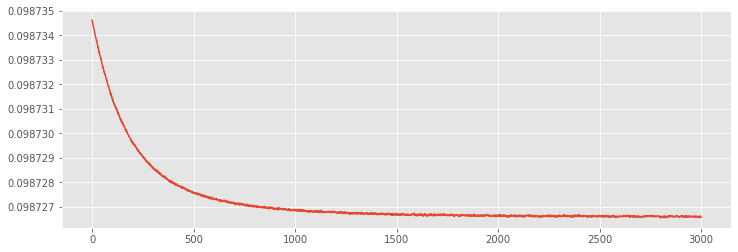

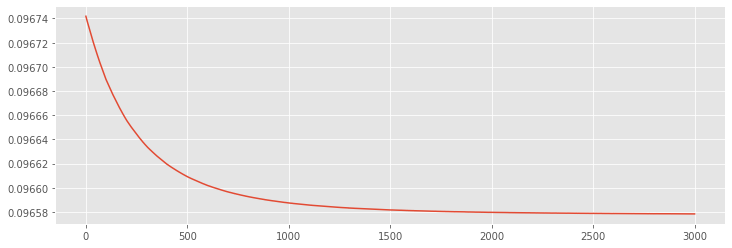

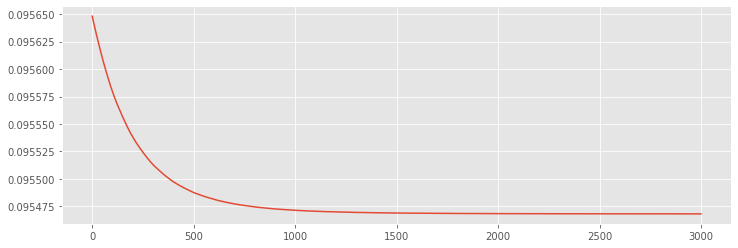

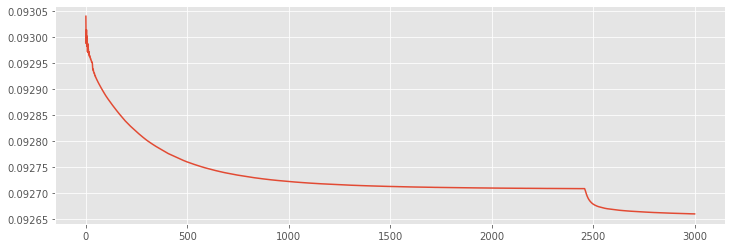

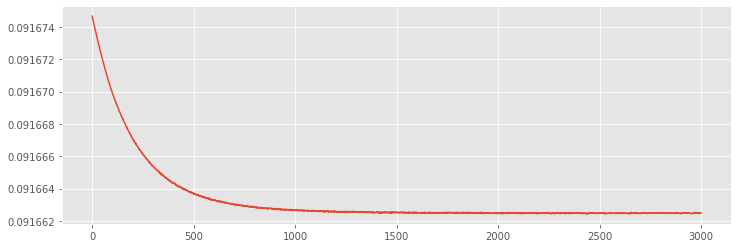

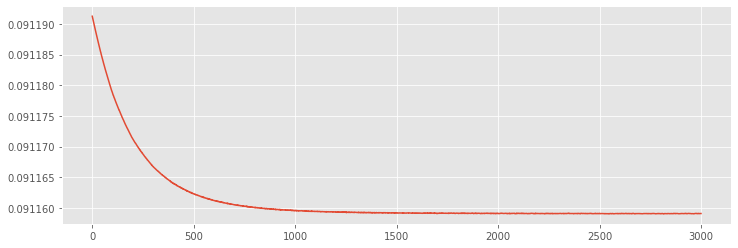

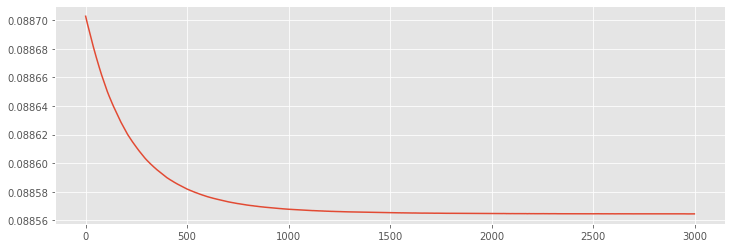

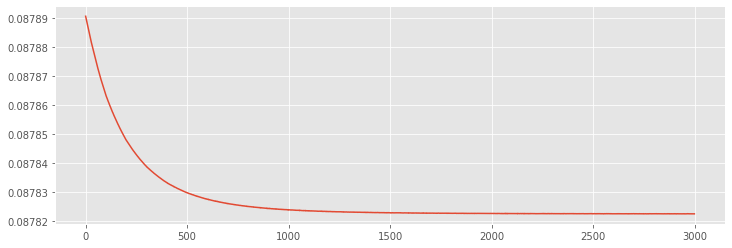

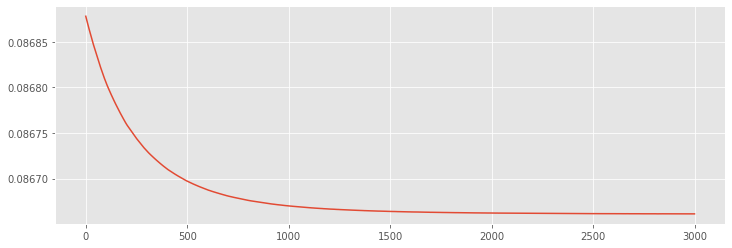

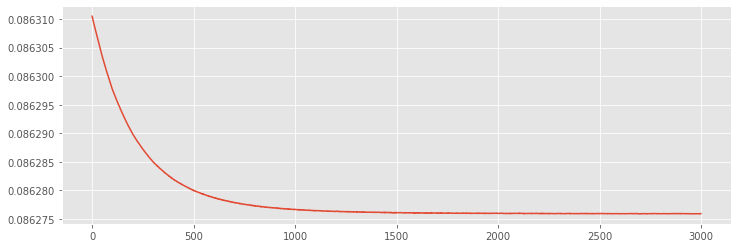

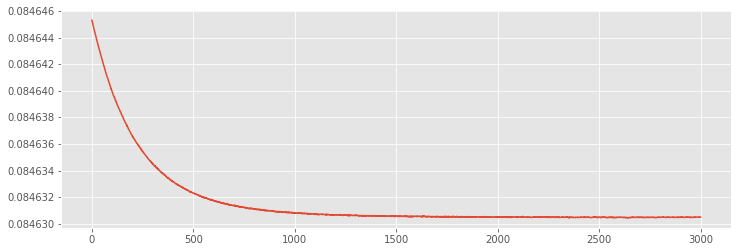

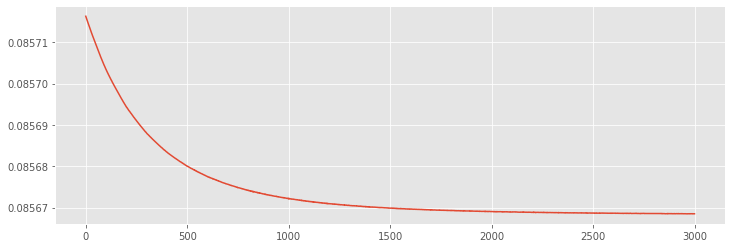

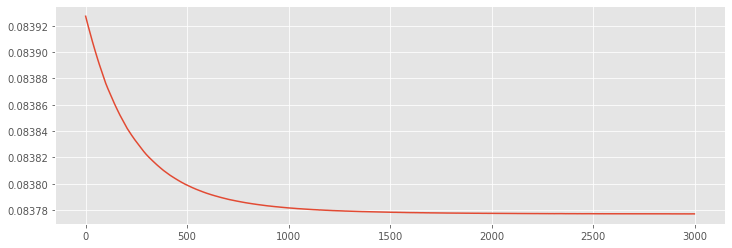

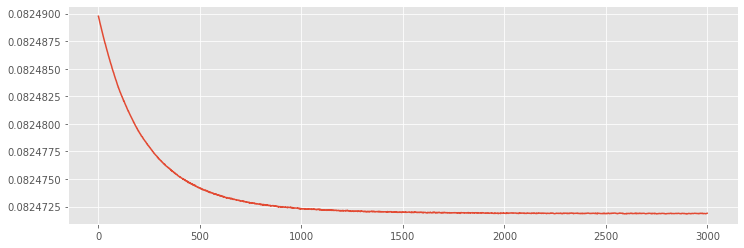

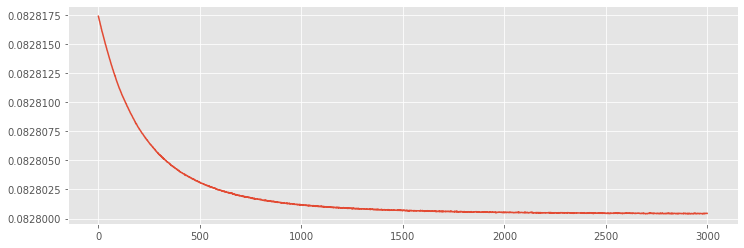

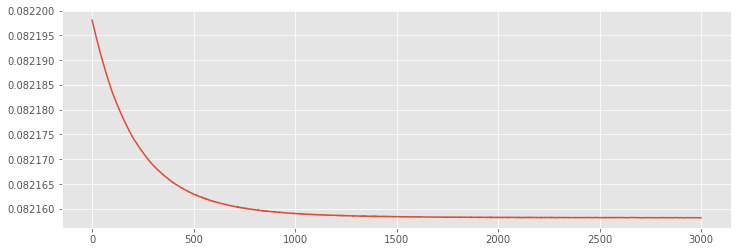

FINISHED


In [119]:
GOOD_FEATURES = ['Stress', 'DTR: véraison - harvest', 'P: fleur', 'Wind: fleur']
coefficients_df = pd.DataFrame(index = range(1994, 2018), columns = ['intercept st_em', 'intercept medoc'] + GOOD_FEATURES)
next_coefficients_df = pd.DataFrame(index = range(1994, 2019), columns = ['intercept st_em', 'intercept medoc'] + GOOD_FEATURES)


for vintage in range(1994, 2018):
    FIRST = 1960
    LAST = vintage - 1
    
    X_tensor_st_em = torch.FloatTensor(X_st_em.loc[FIRST : LAST, :].values)
    y_tensor_st_em = torch.from_numpy(y_st_em.loc[FIRST : LAST, 'Log price'].values)
    X_tensor_medoc = torch.FloatTensor(X_medoc.loc[FIRST : LAST, :].values)
    y_tensor_medoc = torch.from_numpy(y_medoc.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    bayesian=False
    vintage_model = Regressive_Model_Combined(init_dict, training_length, GOOD_FEATURES, bayesian=bayesian)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    if bayesian:
        losses = training_loop_combined_bayesian(vintage_model, str(vintage), optimizer, scheduler, 4000)
    else:
        losses = training_loop_combined(vintage_model, str(vintage), optimizer, scheduler, 4000)
    plt.plot(losses[1000:])
    plt.show()
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]

    coefficients_df.loc[vintage, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept_st_em.detach().numpy()], model_year_range, vintage, verbose=True)[0][0]
    next_coefficients_df.loc[vintage + 1, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept_st_em.detach().numpy()], model_year_range, vintage + 1)[0][0]
    
    coefficients_df.loc[vintage, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept_medoc.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df.loc[vintage + 1, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept_medoc.detach().numpy()], model_year_range, vintage + 1)[0][0]
    
print('FINISHED')

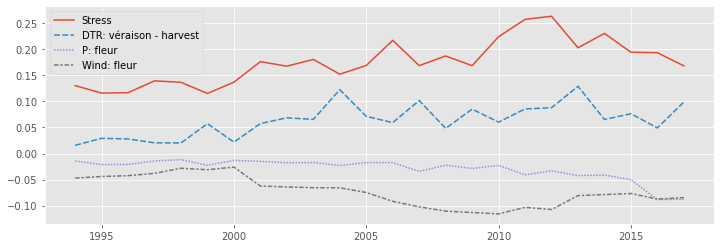

<AxesSubplot:>

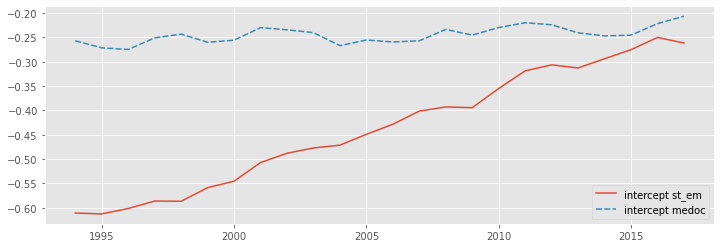

In [120]:
coefficients_df[coefficients_df.columns] = coefficients_df[coefficients_df.columns].apply(pd.to_numeric, errors='coerce', axis=1)

sns.lineplot(data = coefficients_df.iloc[:, 2:])
plt.show()

sns.lineplot(data=coefficients_df.iloc[:, :2])

In [121]:
pnew = 1
pold = 0

predictions_medoc = pd.DataFrame(index = range(1994, 2018), columns = ['Log price'])
predictions_st_em = pd.DataFrame(index = range(1994, 2018), columns = ['Log price'])

for vintage in tqdm(range(1994, 2018)):
    coefficients = coefficients_df.loc[(vintage-1):vintage, :].mean()
    
    if vintage == 1994:
        prediction_st_em = 6 + coefficients_df.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += coefficients_df.loc[vintage, feature] * X_st_em.loc[vintage, feature]
    
    else:
        prediction_st_em = 6 
        prediction_st_em += pnew * coefficients_df.loc[vintage, 'intercept st_em'] + pold * next_coefficients_df.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += (pnew * coefficients_df.loc[vintage, feature] + pold * next_coefficients_df.loc[vintage, feature]) * X_st_em.loc[vintage, feature]
    
    if vintage == 1994:
        prediction_medoc = 6 + coefficients_df.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction_medoc += coefficients_df.loc[vintage, feature] * X_medoc.loc[vintage, feature]
    
    else:
        prediction_medoc = 6 
        prediction_medoc += pnew * coefficients_df.loc[vintage, 'intercept medoc'] + pold * next_coefficients_df.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction_medoc += (pnew * coefficients_df.loc[vintage, feature] + pold * next_coefficients_df.loc[vintage, feature]) * X_medoc.loc[vintage, feature]
   
    predictions_st_em.loc[vintage, 'Log price'] = prediction_st_em
    predictions_medoc.loc[vintage, 'Log price'] = prediction_medoc

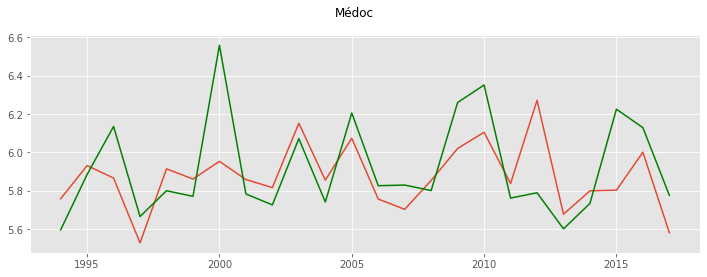

0.629 | 0.225 | 0.241


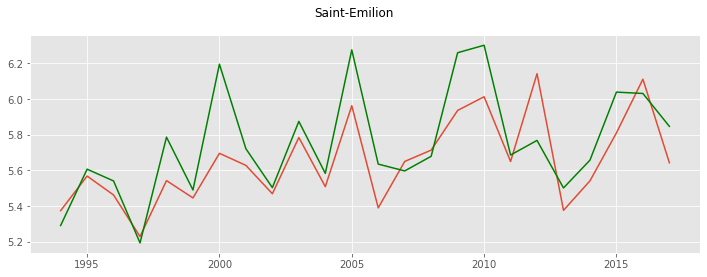

0.861 | 0.534 | 0.312


In [122]:
results_df['Combined VarCoeff'] = 0

plt.plot(range(1994, 2018), predictions_medoc)
plt.suptitle('Médoc')
plt.plot(y_medoc.loc[1994:2017, 'Log price'], color='g')
plt.show()

spearman_r, r2, mae = score_predictions(predictions_medoc, y_medoc['Log price'])
print(spearman_r, '|', r2, '|', mae)
results_df.iloc[0::3, -1] = score_predictions(predictions_medoc, y_medoc['Log price'])

plt.plot(range(1994, 2018), predictions_st_em)
plt.suptitle('Saint-Emilion')
plt.plot(y_st_em.loc[1994:2017, 'Log price'], color='g')
plt.show()

spearman_r, r2, mae = score_predictions(predictions_st_em, y_st_em['Log price'])
print(spearman_r, '|', r2, '|', mae)
results_df.iloc[1::3, -1] = score_predictions(predictions_st_em, y_st_em['Log price'])

Avec 20 sur toutes les reg:
    
- 0.571 | 0.176 | 0.244
- 0.877 | 0.516 | 0.314


Memes params, 2 eme :

- 0.597 | 0.159 | 0.245
- 0.843 | 0.525 | 0.313

Avec 30:
- 0.57 | 0.181 | 0.246
- 0.843 | 0.495 | 0.316


Avec 30, entrainement long et lr basse :
- 0.523 | 0.178 | 0.235
- 0.859 | 0.408 | 0.311

Avec 20, lr 0.01, gamma 0.9 et 3000 epochs
- 0.586 | 0.213 | 0.245
- 0.857 | 0.528 | 0.312


Meme chose, 4000 epochs

- 0.629 | 0.225 | 0.241
- 0.861 | 0.534 | 0.312


In [123]:
predictions_global = 0.5*(predictions_medoc + predictions_st_em)
y_average = 0.5 * (df_medoc['Log price'] + df_st_em['Log price'])

results_df.iloc[2::3, -1] = score_predictions(predictions_global, y_average)
display(results_df)
results_df.to_excel('tables/generated')

,Separate VarCoef,Combined VarCoeff
Médoc: SpearmanR,0.500,0.629
Saint-Émilion: SpearmanR,0.871,0.861
Global: SpearmanR,0.783,0.779
Médoc: R2,0.149,0.225
Saint-Émilion: R2,0.648,0.534
Global: R2,0.486,0.444
Médoc: MAE,0.235,0.241
Saint-Émilion: MAE,0.312,0.312
Global: MAE,0.256,0.259


Combined, with ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur']

>R2 between results and real log prices:
> 0.28574001347365874
>
>Spearman correlation between results and real log prices:
> 0.7347826086956522 

### ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur'], Sur Saint Emilion

Avec aucun smoothing :

>Spearman correlation between results and real log prices: complete
> 0.8226086956521739 
>
>MAE  between results and real log prices: complete
> 0.18230644252901182 
>
>R2 between results and real log prices: complete
> 0.47


Avec smoothing : pas mieux



### Si on inclut le médoc :

St emilion :
>Spearman correlation between results and real log prices: complete
> 0.8391304347826085 
>
>MAE  between results and real log prices: complete
> 0.17323351327890332 
>
>R2 between results and real log prices: complete
> 0.44806926947875536
 
 
Medoc
>Spearman correlation between results and real log prices: complete
> 0.577391304347826 
>
>MAE  between results and real log prices: complete
> 0.19341179729260394 
>
>R2 between results and real log prices: complete
> -0.008350879562910585